In [1]:
%matplotlib inline


# Utilities that assist in building USID Ancillary datasets manually

**Suhas Somnath**

4/18/2018

**This document illustrates certain helper functions that simplify building ancillary Universal Spectroscopy and Imaging Data (USID) datasets manually**


## Introduction
The USID model takes a unique approach towards towards storing scientific observational data. Several helper
functions are necessary to simplify the actual file writing process. In some circunstances, the data does not have an N-dimensonal form and we therefore cannot use the ``pyUSID.Dimension`` objects to define the ancillary Datasets. ``pyUSID.anc_build_utils`` is home for those utilities that assist in manually building ancillary USID datasets but do not directly interact with HDF5 files (as in ``pyUSID.hdf_utils``).

**Note that most of these are low-level functions that are used by popular high level functions in
pyUSID.hdf_utils to simplify the writing of datasets.**

### Recommended pre-requisite reading
* [Universal Spectroscopic and Imaging Data (USID) model](https://pycroscopy.github.io/USID/usid_model.html)

### What to read after this
* [Crash course on HDF5 and h5py](./h5py_primer.html)
* Utilities for [reading](./hdf_utils_read.html) and [writing](./hdf_utils_write.html)
  h5USID files using pyUSID

### Import necessary packages
We only need a handful of packages besides pyUSID to illustrate the functions in ``pyUSID.anc_build_utils``:

* ``numpy`` - for numerical operations on arrays in memory
* ``matplotlib`` - basic visualization of data



In [2]:
from __future__ import print_function, division, unicode_literals
# Warning package in case something goes wrong
from warnings import warn
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
# Finally import pyUSID.
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

## Building Ancillary datasets
The USID model uses pairs of ``ancillary matrices`` to support the instrument-agnostic and compact representation of
multidimensional datasets. While the creation of ``ancillary datasets`` is straightforward when the number of position
and spectroscopic dimensions are relatively small (0-2), one needs to be careful when building these
``ancillary datasets`` for datasets with large number of position / spectroscopic dimensions (> 2). The main challenge
involves the careful tiling and repetition of unit vectors for each dimension with respect to the sizes of all other
dimensions. Fortunately, ``pyUSID.anc_build_utils`` has many handy functions that solve this problem.

In order to demonstrate the functions, lets say that we are working on an example ``Main dataset`` that has three
spectroscopic dimensions (``Bias``, ``Field``, ``Cycle``). The Bias dimension varies as a bi-polar triangular waveform. This
waveform is repeated for two Fields over 3 Cycles meaning that the ``Field`` and ``Cycle`` dimensions are far simpler than
the ``Bias`` dimension in that they have linearly increasing / decreasing values.



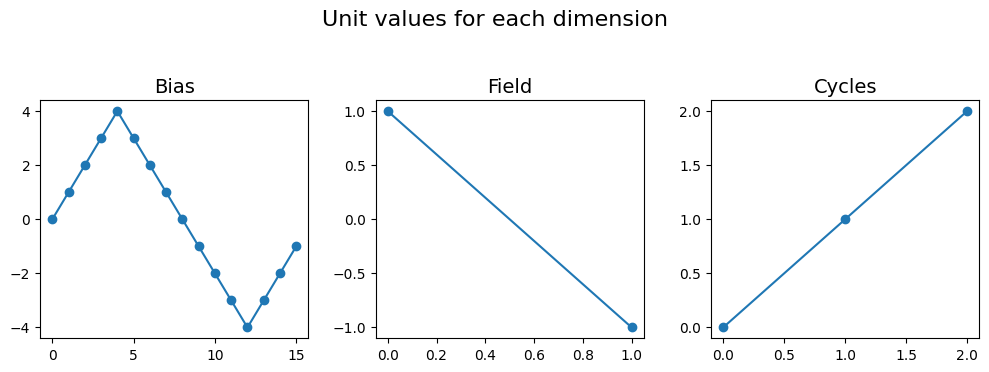

In [3]:
max_v = 4
half_pts = 8
bi_triang = np.roll(np.hstack((np.linspace(-max_v, max_v, half_pts, endpoint=False),
                               np.linspace(max_v, -max_v, half_pts, endpoint=False))), -half_pts // 2)
cycles = [0, 1, 2]
fields = [1, -1]

dim_names = ['Bias', 'Field', 'Cycles']

fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5))
for axis, name, vec in zip(axes.flat, dim_names, [bi_triang, fields, cycles]):
    axis.plot(vec, 'o-')
    axis.set_title(name, fontsize=14)
fig.suptitle('Unit values for each dimension', fontsize=16, y=1.05)
fig.tight_layout()

### make_indices_matrix()
One half of the work for generating the ancillary datasets is generating the ``indices matrix``. The
``make_indices_matrix()`` function solves this problem. All one needs to do is supply a list with the lengths of each
dimension. The result is a 2D matrix of shape: (3 dimensions, points in ``Bias``[``16``] * points in ``Field``[``2``] * points
in ``Cycle``[``3``]) = ``(3, 96)``.



Generated indices of shape: (3, 96)


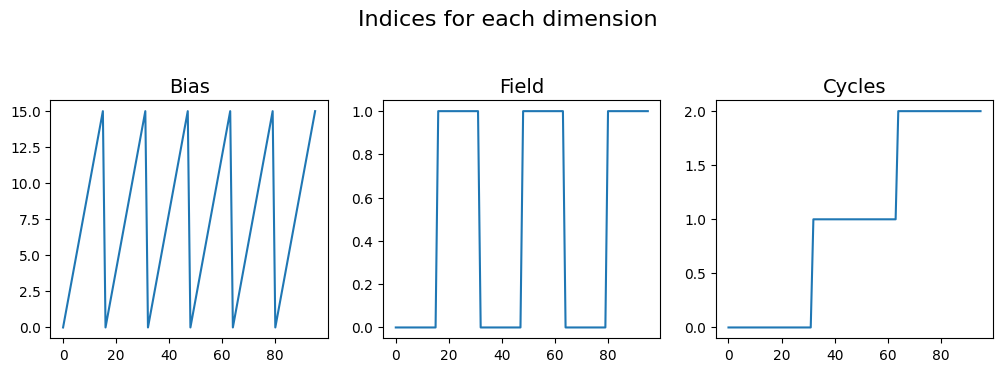

In [4]:
inds = usid.anc_build_utils.make_indices_matrix([len(bi_triang), len(fields), len(cycles)], is_position=False)
print('Generated indices of shape: {}'.format(inds.shape))

# The plots below show a visual representation of the indices for each dimension:
fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5))
for axis, name, vec in zip(axes.flat, dim_names, inds):
    axis.plot(vec)
    axis.set_title(name, fontsize=14)
fig.suptitle('Indices for each dimension', fontsize=16, y=1.05)
fig.tight_layout()

### build_ind_val_matrices()
``make_indices_matrix()`` is a very handy function but it only solves one of the problems - the indices matrix. We also
need the matrix with the values tiled and repeated in the same manner. Perhaps one of the most useful functions is
``build_ind_val_matrices()`` which uses just the values over which each dimension is varied to automatically generate
the indices and values matrices that form the ancillary datasets.

In order to generate the indices and values matrices, we would just need to provide the list of values over which
these dimensions are varied to ``build_ind_val_matrices()``. The results are two matrices - one for the indices and the
other for the values, of the same shape ``(3, 96)``.

As mentioned in our document about the `data structuring <../../data_format.html>`_,
the ``Bias`` would be in the first row, followed by ``Field``, finally followed by ``Cycle``. The plots below illustrate
what the indices and values look like for each dimension. For example, notice how the bipolar triangular bias vector
has been repeated 2 (``Field``) * 3 (``Cycle``) times. Also note how the indices vector is a saw-tooth waveform that also
repeats in the same manner.  The repeated + tiled indices and values vectors for ``Cycle`` and ``Field`` look the same /
very similar since they were simple linearly increasing values to start with.



Indices and values of shape: (3, 96)


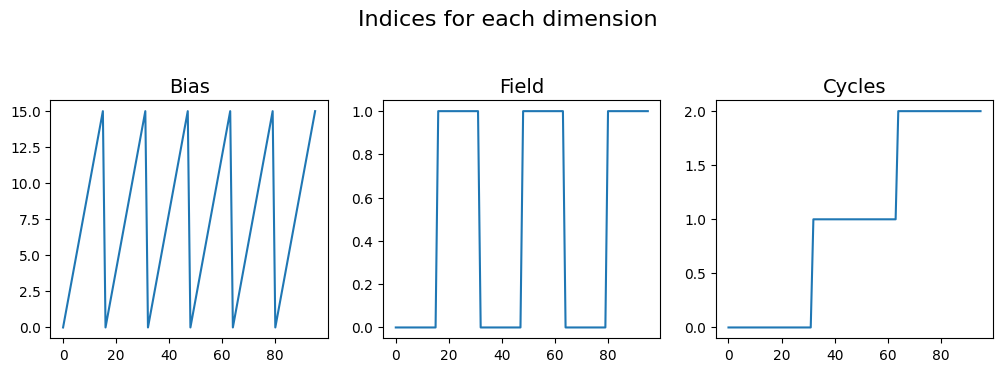

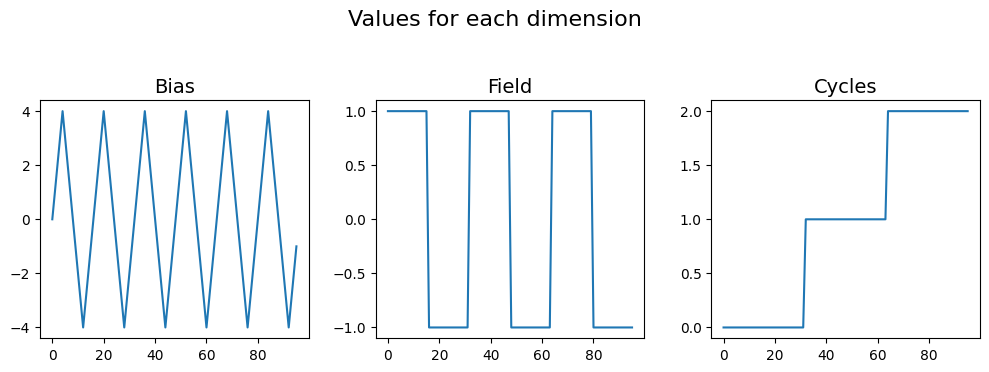

In [5]:
inds, vals = usid.anc_build_utils.build_ind_val_matrices([bi_triang, fields, cycles], is_spectral=True)
print('Indices and values of shape: {}'.format(inds.shape))

fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5))
for axis, name, vec in zip(axes.flat, dim_names, inds):
    axis.plot(vec)
    axis.set_title(name, fontsize=14)
fig.suptitle('Indices for each dimension', fontsize=16, y=1.05)
fig.tight_layout()

fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5))
for axis, name, vec in zip(axes.flat, dim_names, vals):
    axis.plot(vec)
    axis.set_title(name, fontsize=14)
fig.suptitle('Values for each dimension', fontsize=16, y=1.05)
fig.tight_layout()

### create_spec_inds_from_vals()
When writing analysis functions or classes wherein one or more (typically spectroscopic) dimensions are dropped as a
consequence of dimensionality reduction, new ancillary spectroscopic datasets need to be generated when writing the
reduced data back to the file. ``create_spec_inds_from_vals()`` is a handy function when we need to generate the indices
matrix that corresponds to a values matrix. For this example, lets assume that we only have the values matrix but need
to generate the indices matrix from this:



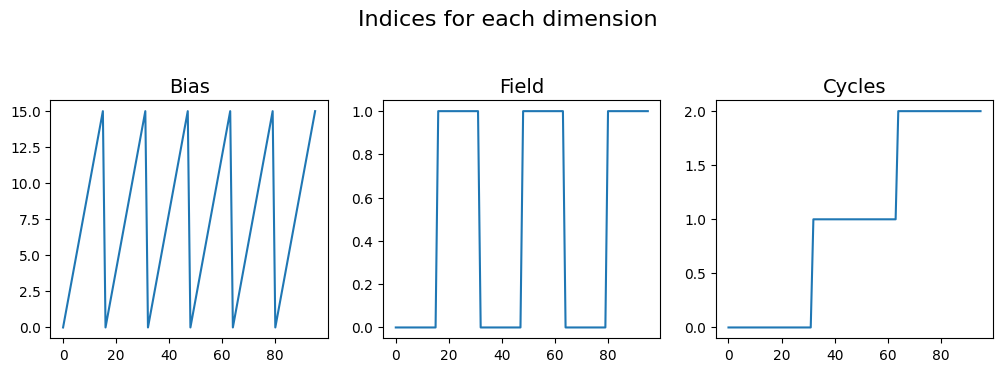

In [6]:
inds = usid.anc_build_utils.create_spec_inds_from_vals(vals)

fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5))
for axis, name, vec in zip(axes.flat, dim_names, inds):
    axis.plot(vec)
    axis.set_title(name, fontsize=14)
fig.suptitle('Indices for each dimension', fontsize=16, y=1.05)
fig.tight_layout()

### get_aux_dset_slicing()
``Region references`` are a handy feature in HDF5 that allow users to refer to a certain section of data within a
dataset by name rather than the indices that define the region of interest.

In USID, we use region references to define the row or column in the ``ancillary dataset`` that corresponds to
each dimension by its name. In other words, if we only wanted the ``Field`` dimension we could directly get the data
corresponding to this dimension without having to remember or figure out the index in which this dimension exists.

Let's take the example of the Field dimension which occurs at index 1 in the ``(3, 96)`` shaped spectroscopic index /
values matrix. We could extract the ``Field`` dimension from the 2D matrix by slicing each dimension using slice objects
. We need the second row so the first dimension would be sliced as ``slice(start=1, stop=2)``. We need all the colummns
in the second dimension so we would slice as ``slice(start=None, stop=None)`` meaning that we need all the columns.
Doing this by hand for each dimension is clearly tedious.

``get_aux_dset_slicing()`` helps generate the instructions for region references for each dimension in an ancillary
dataset. The instructions for each region reference in ``h5py`` are defined by tuples of slice objects. Lets see the
region-reference instructions that this function provides for our aforementioned example dataset with the three
spectroscopic dimensions.



In [7]:
print('Region references slicing instructions for Spectroscopic dimensions:')
ret_val = usid.anc_build_utils.get_aux_dset_slicing(dim_names, is_spectroscopic=True)
for key, val in ret_val.items():
    print('{} : {}'.format(key, val))

print('\nRegion references slicing instructions for Position dimensions:')
ret_val = usid.anc_build_utils.get_aux_dset_slicing(['X', 'Y'], is_spectroscopic=False)
for key, val in ret_val.items():
    print('{} : {}'.format(key, val))

Region references slicing instructions for Spectroscopic dimensions:
Bias : (slice(0, 1, None), slice(None, None, None))
Field : (slice(1, 2, None), slice(None, None, None))
Cycles : (slice(2, 3, None), slice(None, None, None))

Region references slicing instructions for Position dimensions:
X : (slice(None, None, None), slice(0, 1, None))
Y : (slice(None, None, None), slice(1, 2, None))


## Dimension
In USID, ``position`` and ``spectroscopic dimensions`` are defined using some basic information that will be
incorporated in ``Dimension`` objects that contain three vital pieces of information:

* ``name`` of the dimension
* ``units`` for the dimension
* ``values``:
    * These can be the actual values over which the dimension was varied
    * or number of steps in case of linearly varying dimensions such as 'Cycle' below

These objects will be heavily used for creating ``Main`` or ``ancillary datasets`` in ``pyUSID.hdf_utils`` and even to
set up interactive jupyter Visualizers in ``pyUSID.USIDataset``.

Note that the ``Dimension`` objects in the lists for ``Position`` and ``Spectroscopic`` must be arranged from fastest
varying to slowest varying to mimic how the data is actually arranged. For example, in this example, there are
multiple bias points per field and multiple fields per cycle. Thus, the bias changes faster than the field and the
field changes faster than the cycle. Therefore, the ``Bias`` must precede ``Field`` which will precede ``Cycle``. Let's
assume that we were describing the spectroscopic dimensions for this example dataset to some other pyUSID function
, we would describe the spectroscopic dimensions as:



In [8]:
spec_dims = [usid.Dimension('Bias', 'V', bi_triang),
             usid.Dimension('Fields', '', fields),
             # for the sake of example, since we know that cycles is linearly increasing from 0 with a step size of 1,
             # we can specify such a simply dimension via just the length of that dimension:
             usid.dimension.Dimension('Cycle', '', len(cycles))]

AttributeError: module 'pyUSID' has no attribute 'dimension'

The application of the Dimension objects will be a lot more apparent in the document about the [writing functions in
pyUSID.hdf_utils](./hdf_utils_write.html).

## Misc writing utilities

### calc_chunks()
The ``h5py`` package automatically (virtually) breaks up HDF5 datasets into contiguous ``chunks`` to speed up reading and
writing of datasets. In certain situations the default mode of chunking may not result in the highest performance.
In such cases, it helps in chunking the dataset manually. The ``calc_chunks()`` function helps in calculating
appropriate chunk sizes for the dataset using some apriori knowledge about the way the data would be accessed, the
size of each element in the dataset, maximum size for a single chunk, etc. The examples below illustrate a few ways on
how to use this function:



In [9]:
dimensions = (16384, 16384 * 4)
dtype_bytesize = 4
ret_val = usid.anc_build_utils.calc_chunks(dimensions, dtype_bytesize)
print(ret_val)

dimensions = (16384, 16384 * 4)
dtype_bytesize = 4
unit_chunks = (3, 7)
max_mem = 50000
ret_val = usid.anc_build_utils.calc_chunks(dimensions, dtype_bytesize, unit_chunks=unit_chunks, max_chunk_mem=max_mem)
print(ret_val)

(np.uint64(26), np.uint64(100))
(np.uint64(57), np.uint64(224))
